<h1 style="font-size: 32px; font-weight: bold;">Semantic Segmentation Competition (30%)</h1>

For this competition, we will use a small autonomous driving dataset. The dataset contains 150 training images and 50 testing images.

**We provide baseline code that includes the following features:**

*    Loading the dataset using PyTorch.
*    Defining a simple convolutional neural network for semantic segmentation.
*    How to use existing loss function for the model learning.
*    Train the network on the training data.
*    Test the trained network on the testing data.
<br/><br/>

**The following changes could be considered:**

1. Data augmentation
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, and Drop-out.
3. Architectural changes: Batch Normalization, Residual layers, etc.
4. Use of a new loss function.

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.
<br/><br/>


**Marking Rules:**

We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = accuracy mark + efficiency mark + report mark
<br/><br/>


***Accuracy Mark 10:***

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.
<br/><br/>


***Efficiency Mark 10:***

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.
<br/><br/>


***Report mark 30:***

**Your report should comprise:**

1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

> A recommended way to present a summary of this is via an "ablation study" table, eg:

> |Method1|Method2|Method3|Accuracy|
> |---|---|---|---|
> |N|N|N|60%|
> |Y|N|N|65%|
> |Y|Y|N|77%|
> |Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]

# **1. Download Data & Set Configurations**

In [1]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: Max Busato, Liam Hennig
### Student ID: a1851532, ?
### Comptetion Name: Semantic Segmentation Competition
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

## **Download the Dataset**

Dowanload & Unzip the Dataset.
<br/><br/>

## **Set Configurations**

In [2]:
# ------------------------ Standard Library ------------------------
import shutil

# ----------------- Scientific & Imaging Libraries -----------------
import numpy as np
from PIL import Image

# -------------------------- PyTorch Core --------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torchvision.models as models

# ------------------------ PyTorch Utilities --------------------------
import torchvision.transforms as tf
import torchvision.models.segmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

# -------------------------- Additional Codebooks ----------------------
from Road_Segmentation_Utils import *

#-------------------------------- Data path -----------------------------
# Use your data path to replace the following path if you use Google drive.
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset Path. Ensure that the File Path Corresponds to the Path you Have Here. It is Expected that you Unzip the Data Folders before Running the Notebook.
dataFolder = '/home/hal-9000/Documents/Computer-Vision/seg_data'

# To access Google Colab GPU; Go To: Edit >>> Notebook Settings >>> Hardware Accelarator: Select GPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: {}'.format(device))

/home/hal-9000/Documents/Computer-Vision/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


<br/>

## **Edit Configurations to Tune Model Performance**

These settings should be altered as part of the model's analysis. You could consider changing the training hyperparameters: Learning Rate, Optimiser, Batch-size, Number of Max Epochs

In [3]:
# Editable Configuration Settings
learning_rate = 1e-3 # Using a Learning Rate Scheduler
width = 864
height = 256 
batchSize = 4 # Can Be Adjusted
epochs = 350  # Can Be Adjusted

# Data Check
if not os.path.exists(dataFolder):
  print('Data Path Error! Please check your data path')

# CUDA Check
if not torch.cuda.is_available():
  print('WARNING! The device is CPU NOT GPU! Please avoid using CPU for training')

<br/><br/>

# **Define a Dataloader to Load Data**

Add in better more systematic data transformations here. Data augmentation can be used (for example flip, resize). You should consider additional/better data augmentation, especially since there are so few training images for the model to learn from. 

In [4]:
# The Class to Load Images & Labels
class ExpDataSet(Dataset):
    def __init__(self, dataFolder):
        # Define the Paths to the Training Image & Label Directories
        self.image_dir = os.path.join(dataFolder, "training/image")
        self.label_dir = os.path.join(dataFolder, "training/label")

        # List & Sort All Image & Label Filenames to Ensure Correct Alignment
        self.image_path = sorted(os.listdir(self.image_dir))
        self.label_path = sorted(os.listdir(self.label_dir))

        # Print the Number of Samples Loaded
        print(f'Loaded info for {len(self.image_path)} images')

        # Ensure that the Number of Images is Exactly What We Expect (sanity check)
        assert len(self.image_path) == 150

        # Loop Through Each Index To:
            # Check that Image & Label Filenames Match
            # Store Full Paths (Including Directory) for Loading Later
        for idx in range(len(self.image_path)):
            assert self.image_path[idx] == self.label_path[idx], f"Image and label filenames do not match at index {idx}"
            self.image_path[idx] = os.path.join(self.image_dir, self.image_path[idx])
            self.label_path[idx] = os.path.join(self.label_dir, self.label_path[idx])
            
            
        # -------------------------------- Transformation Functions --------------------------------
        self.transform = A.Compose([
            # Resize to Fixed Size
            A.Resize(height, width, interpolation=cv2.INTER_NEAREST),

            # Geometric Augmentations
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=0.1,
                rotate_limit=20,
                border_mode=cv2.BORDER_CONSTANT,  # Use Constant Padding
                p=0.4
            ),

            # Photometric Augmentations (Only On Images, Won't Affect Masks)
            A.RandomBrightnessContrast(p=0.3),
            A.ColorJitter(p=0.3),
            A.HueSaturationValue(p=0.3),

            # Blurring/Noise
            A.OneOf([
                A.MotionBlur(p=0.2), 
                A.GaussianBlur(p=0.2), 
                A.GaussNoise(p=0.2)
            ], p=0.2),

            # Normalisation
            A.Normalize(mean=(0.485, 0.456, 0.406), 
                        std=(0.229, 0.224, 0.225)),

            # Convert to PyTorch Tensor
            ToTensorV2()
        ])
        # ------------------------------------------------------------------------------------------


    def __getitem__(self, idx):
        # Load Image & Label Using OpenCV
        img = cv2.imread(self.image_path[idx])[:, :, ::-1]  # Convert BGR to RGB
        label = cv2.imread(self.label_path[idx], cv2.IMREAD_GRAYSCALE)

        # Apply Albumentations (With Nearest-Neighbour Mask Handling)
        augmented = self.transform(image=img, mask=label)
        img = augmented['image']           # Tensor: (3, H, W)
        label = augmented['mask'].long()   # Tensor: (H, W), type: long

        # Return the Image & Mask
        return img, label


    def __len__(self):
        return len(self.image_path)


# Get the Predefined Dataloader
exp_data = ExpDataSet(dataFolder)
train_loader = DataLoader(exp_data, batch_size=batchSize, shuffle=True, num_workers=2)

Loaded info for 150 images


/home/hal-9000/Documents/Computer-Vision/.venv/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


<br/><br/>

# **Define a Convolutional Neural Network**

A new network should be used. Many architectural changes can be implemented, such as, Batch Normalisation, More layers, Residual layers, anything else you deem fit. Also consdier using regularisations such as Drop-Out.

It is strongly suggested that for this task, due to the low number of training images, pre-training on a larger dataset *(a form of 'transfer learning')* should be implemented. 

In [5]:
# Decoder Block Using U-Net Style Concatenation
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(8, out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(8, out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        # Upsample x to Match Skip Spatial Size
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)

        # Concatenate Along Channels
        x = torch.cat([x, skip], dim=1)
        x = self.relu1(self.gn1(self.conv1(x)))
        x = self.relu2(self.gn2(self.conv2(x)))
        
        # Return th Result
        return x

In [6]:
# Define a Main Semantic Segmentation Network
class BetterSegNetwork(nn.Module):
    def __init__(self, n_class=19):
        super(BetterSegNetwork, self).__init__()

        # ----------------------------- Build a Custom Encoder -------------------------------
        # Stage 1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.gn1_1 = nn.GroupNorm(8, 64)
        self.relu1_1 = nn.ReLU(inplace=True)

        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.gn1_2 = nn.GroupNorm(8, 64)
        self.relu1_2 = nn.ReLU(inplace=True)

        self.conv1_3 = nn.Conv2d(64, 64, 3, padding=1)
        self.gn1_3 = nn.GroupNorm(8, 64)
        self.relu1_3 = nn.ReLU(inplace=True)

        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/2
        

        # Stage 2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.gn2_1 = nn.GroupNorm(8, 128)
        self.relu2_1 = nn.ReLU(inplace=True)

        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.gn2_2 = nn.GroupNorm(8, 128)
        self.relu2_2 = nn.ReLU(inplace=True)

        self.conv2_3 = nn.Conv2d(128, 128, 3, padding=1)
        self.gn2_3 = nn.GroupNorm(8, 128)
        self.relu2_3 = nn.ReLU(inplace=True)

        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/4


        # Stage 3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.gn3_1 = nn.GroupNorm(8, 256)
        self.relu3_1 = nn.ReLU(inplace=True)

        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.gn3_2 = nn.GroupNorm(8, 256)
        self.relu3_2 = nn.ReLU(inplace=True)

        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.gn3_3 = nn.GroupNorm(8, 256)
        self.relu3_3 = nn.ReLU(inplace=True)

        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/8
    

        # Stage 4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.gn4_1 = nn.GroupNorm(8, 512)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.drop4_1 = nn.Dropout2d(0.1)

        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.gn4_2 = nn.GroupNorm(8, 512)
        self.relu4_2 = nn.ReLU(inplace=True)

        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.gn4_3 = nn.GroupNorm(8, 512)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.drop4_3 = nn.Dropout2d(0.1)

        self.pool4 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/16
    

        # Stage 5
        self.conv5_1 = nn.Conv2d(512, 1024, 3, padding=2, dilation=2)  # dilation=2 expands receptive field
        self.gn5_1 = nn.GroupNorm(8, 1024)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.drop5_1 = nn.Dropout2d(0.2)

        self.conv5_2 = nn.Conv2d(1024, 1024, 3, padding=2, dilation=2)
        self.gn5_2 = nn.GroupNorm(8, 1024)
        self.relu5_2 = nn.ReLU(inplace=True)

        self.conv5_3 = nn.Conv2d(1024, 1024, 3, padding=2, dilation=2)
        self.gn5_3 = nn.GroupNorm(8, 1024)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.drop5_3 = nn.Dropout2d(0.2)

        # self.pool5 = nn.MaxPool2d(2, 2, ceil_mode=True)  # Comment this out or adjust stride
        # --------------------------------------------------------------------------------------


        # Center Block (Switch Direction)
        self.center_conv1 = nn.Conv2d(1024, 512, 3, padding=4, dilation=4)  # Bigger Dilation Here
        self.center_gn1 = nn.GroupNorm(8, 512)
        self.center_relu1 = nn.ReLU(inplace=True)

        self.center_conv2 = nn.Conv2d(512, 512, 3, padding=4, dilation=4)
        self.center_gn2 = nn.GroupNorm(8, 512)
        self.center_relu2 = nn.ReLU(inplace=True)


        # ------------------------------- Build a Custom Decoder -----------------------------------------
        self.dec5 = DecoderBlock(in_channels=512, skip_channels=512, out_channels=512)  # 512 + 512 -> 512
        self.dec4 = DecoderBlock(in_channels=512, skip_channels=256, out_channels=256)  # 512 + 256 -> 256
        self.dec3 = DecoderBlock(in_channels=256, skip_channels=128, out_channels=128)  # 256 + 128 -> 128
        self.dec2 = DecoderBlock(in_channels=128, skip_channels=64, out_channels=64)    # 128 + 64 -> 64
        # ------------------------------------------------------------------------------------------------


        # Final Segmentation Head: Predict n_class Channels
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Dropout2d(0.1),  # Helps Generalise with Small Datasets
            nn.Conv2d(32, n_class, kernel_size=1)
        )


    def forward(self, x):
        # Stage 1
        x = self.relu1_1(self.gn1_1(self.conv1_1(x)))
        x = self.relu1_2(self.gn1_2(self.conv1_2(x)))
        c1 = self.pool1(x)  # --> 1/2

        # Stage 2
        x = self.relu2_1(self.gn2_1(self.conv2_1(c1)))
        x = self.relu2_2(self.gn2_2(self.conv2_2(x)))
        c2 = self.pool2(x)  # --> 1/4

        # Stage 3
        x = self.relu3_1(self.gn3_1(self.conv3_1(c2)))
        x = self.relu3_2(self.gn3_2(self.conv3_2(x)))
        c3 = self.pool3(x)  # --> 1/8

        # Stage 4
        x = self.drop4_1(self.relu4_1(self.gn4_1(self.conv4_1(c3))))
        x = (self.relu4_2(self.gn4_2(self.conv4_2(x))))
        c4 = self.pool4(x)  # --> 1/16

        # Stage 5
        x = self.drop5_1(self.relu5_1(self.gn5_1(self.conv5_1(c4))))
        x = (self.relu5_2(self.gn5_2(self.conv5_2(x))))

        # Center (Switch Direction)
        x = self.center_relu1(self.center_gn1(self.center_conv1(x)))
        x = self.center_relu2(self.center_gn2(self.center_conv2(x)))

        # Decoder with Concatenation
        x = self.dec5(x, c4)  # 1/16 scale
        x = self.dec4(x, c3)  # 1/8 scale
        x = self.dec3(x, c2)  # 1/4 scale
        x = self.dec2(x, c1)  # 1/2 scale

        # Final Upsample to Original Input Size (assumes input downscaled 1/2)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        # Final Segmentation Prediction
        out = self.segmentation_head(x)  # (B, n_class, H, W)

        return out

In [7]:
# Get the Predefined Network
segNet = BetterSegNetwork(n_class=19).to(device)

# Print mMdel Summary With Input Size (batch_size, channels, height, width)
summary(segNet, input_size=(1, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
BetterSegNetwork                         [1, 19, 256, 864]         12,576,576
├─Conv2d: 1-1                            [1, 64, 256, 864]         1,792
├─GroupNorm: 1-2                         [1, 64, 256, 864]         128
├─ReLU: 1-3                              [1, 64, 256, 864]         --
├─Conv2d: 1-4                            [1, 64, 256, 864]         36,928
├─GroupNorm: 1-5                         [1, 64, 256, 864]         128
├─ReLU: 1-6                              [1, 64, 256, 864]         --
├─MaxPool2d: 1-7                         [1, 64, 128, 432]         --
├─Conv2d: 1-8                            [1, 128, 128, 432]        73,856
├─GroupNorm: 1-9                         [1, 128, 128, 432]        256
├─ReLU: 1-10                             [1, 128, 128, 432]        --
├─Conv2d: 1-11                           [1, 128, 128, 432]        147,584
├─GroupNorm: 1-12                        [1, 128, 128, 432

In [8]:
# ---------------------------- Build a Custom Loss Function ----------------------------------------
class DiceLoss(nn.Module):
    def __init__(self, num_classes=19, ignore_index=255, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        preds: (B, C, H, W) - logits from model
        targets: (B, H, W) - ground truth labels
        """
        # Create Mask for Valid Pixels (not ignored)
        mask = (targets != self.ignore_index)
        
        # Apply Softmax to Predictions
        preds = F.softmax(preds, dim=1)

        # Set Ignored Pixels in Targets to Zero (just to avoid errors in one_hot)
        targets_clamped = targets.clone()
        targets_clamped[~mask] = 0          # Arbitrary Valid Class to Not Break One_Hot

        # One-Hot Encode Targets
        targets_one_hot = F.one_hot(targets_clamped, self.num_classes).permute(0, 3, 1, 2).float()

        # Mask Out Ignored Pixels in Both Preds & Targets
        mask = mask.unsqueeze(1)  # shape (B,1,H,W) for broadcasting
        preds = preds * mask
        targets_one_hot = targets_one_hot * mask

        # Flatten Predictions & Targets
        preds = preds.contiguous().view(preds.size(0), self.num_classes, -1)
        targets_one_hot = targets_one_hot.contiguous().view(targets.size(0), self.num_classes, -1)

        # Compute Intersection & Union
        intersection = (preds * targets_one_hot).sum(dim=2)
        union = preds.sum(dim=2) + targets_one_hot.sum(dim=2)

        # Dice & Return
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [9]:
# Define the Loss Function
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

# Define the Optimiser
optimizer = torch.optim.AdamW(
    params=segNet.parameters(), 
    lr=learning_rate,      # Lower Learning Rate to Avoid Overfitting
    weight_decay=1e-4      # Helps Prevent Overfitting (Regularisation)
)

# Define the Leanring Rate Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=1e-6)

<br/><br/>

# **The Function Used to Compare the Precision**

**DO NOT MODIFY THIS CODE!**

In [10]:
def cal_acc(pred_folder, gt_folder, classes=19):
    class AverageMeter(object):
        def __init__(self):
            self.reset()
        def reset(self):
            self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
    def intersectionAndUnion(output, target, K, ignore_index=255):
        assert (output.ndim in [1, 2, 3])
        assert output.shape == target.shape
        output = output.reshape(output.size).copy()
        target = target.reshape(target.size)
        output[np.where(target == ignore_index)[0]] = ignore_index
        intersection = output[np.where(output == target)[0]]
        area_intersection, _ = np.histogram(intersection, bins=np.arange(K + 1))
        area_output, _ = np.histogram(output, bins=np.arange(K + 1))
        area_target, _ = np.histogram(target, bins=np.arange(K + 1))
        area_union = area_output + area_target - area_intersection
        return area_intersection, area_union, area_target
    data_list = os.listdir(gt_folder)
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    for i, image_name in enumerate(data_list):
        pred = cv2.imread(os.path.join(pred_folder, image_name), cv2.IMREAD_GRAYSCALE)
        target = cv2.imread(os.path.join(gt_folder, image_name), cv2.IMREAD_GRAYSCALE)
        intersection, union, target = intersectionAndUnion(pred, target, classes)
        intersection_meter.update(intersection)
        union_meter.update(union)
        target_meter.update(target)
    iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
    mIoU = np.mean(iou_class)
    print('Eval result: mIoU {:.4f}.'.format(mIoU))
    return mIoU

<br/><br/>

# **Define Functions to Get & Save Predictions**

Multi-scale testing can be used here to reduce the number of training cycles needed to evaluate model parameters' effectiveness.

In [11]:
# Create a Directory if it Does Not Already Exist
def make_folder(dir_name): 
    if not os.path.exists(dir_name):
        # Create the Directory & Any Necessary Parent Directories
        os.makedirs(dir_name)  


# Move All Files From Temporary Prediction Folders to Result Folders & Remove Temporary Folders
def move_folders(grey_temp, color_temp, grey_rs, color_rs):
    # If Temporary Grayscale Prediction Folder Exists
    if os.path.exists(grey_temp):
        # Ensure Destination Folder Exists
        make_folder(grey_rs)  

        # Move Each File From Temp to Result Directory
        for file in os.listdir(grey_temp):
            shutil.move(os.path.join(grey_temp, file), os.path.join(grey_rs, file))

        # Remove the Temp Folder if it Still Exists After Moving
        if os.path.exists(grey_temp):
            shutil.rmtree(grey_temp)

    # Same Process for the Colour Prediction Folder
    if os.path.exists(color_temp):
        make_folder(color_rs)
        for file in os.listdir(color_temp):
            shutil.move(os.path.join(color_temp, file), os.path.join(color_rs, file))
        if os.path.exists(color_temp):
            shutil.rmtree(color_temp)


# Convert a Grayscale Mask (With Class Indices) to a Colorised Image Using a Palette
def colorize(gray, palette):
    # Convert the Grayscale NumPy Array to a PIL Image in 'P' Mode (Palette-Based)
    color = Image.fromarray(gray.astype(np.uint8)).convert('P')
    
    # Apply the Palette (A Flat List of RGB Triplets For Each Class Index)
    color.putpalette(palette)

    # Return the Colorised Image
    return color



#--------------------------- PERFORM EVALUATION FOR A NETWORK & SAVE PREDICTION RESULTS -----------------------
def get_predictions(segNet, dataFolder, device):
    # Define Folders to Save Grayscale & Colour Predictions
    gray_folder, color_folder, model_folder = './TempFiles/temp_grey', './TempFiles/temp_color', './Models'
    
    # List All Image Filenames in the Testing Images Folder
    listImages = os.listdir(os.path.join(dataFolder, "testing/image"))
    
    # Define the Path to Ground Truth Label Folder
    gt_folder = os.path.join(dataFolder, "testing/label")
    
    # Path to Colour Palette for Visualisation
    colors_path  = os.path.join(dataFolder, "colors.txt")
    print('Begin Testing')
    
    # Create Folders if They Don't Exist
    make_folder(gray_folder)
    make_folder(color_folder)
    make_folder(model_folder)
    
    # Load Colours for Visualising Grayscale Masks as RGB
    colors = np.loadtxt(colors_path).astype('uint8')

    # Albumentations Transform with Resize + Normalise + Tensor
    transformTest = A.Compose([
        A.Resize(height, width, interpolation=cv2.INTER_LINEAR),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    # Make Sure Model is in Eval Mode
    segNet.eval()  

    # Iterate Over All Images to Predict
    with torch.no_grad():
        for img_name in listImages:
            img_path = os.path.join(dataFolder, "testing/image", img_name)
            img = cv2.imread(img_path)[:, :, ::-1]  # BGR to RGB
            
            # Apply Albumentations transform
            augmented = transformTest(image=img)
            img_tensor = augmented['image'].unsqueeze(0).to(device)  # (1,3,H,W)

            prediction = segNet(img_tensor)[0].cpu().numpy()
            prediction = np.argmax(prediction, axis=0)  # (H, W)

            gt_mask = cv2.imread(os.path.join(gt_folder, img_name), cv2.IMREAD_GRAYSCALE)
            gt_h, gt_w = gt_mask.shape

            # Resize prediction to original GT size using nearest neighbor
            prediction_resized = cv2.resize(prediction, (gt_w, gt_h), interpolation=cv2.INTER_NEAREST)
            gray = np.uint8(prediction_resized)
            color = colorize(gray, colors)

            gray_path = os.path.join(gray_folder, img_name)
            color_path = os.path.join(color_folder, img_name)

            cv2.imwrite(gray_path, gray) # type: ignore
            color.save(color_path)

    return gray_folder, color_folder
# -----------------------------------------------------------------------------------------------------------------

<br/><br/>

# **Train the Network**

Training on the original base model will take ~1 hour to complete. It is possible to define the false case in order to save on training time. Remember to download the results before closing the notebook.

In [12]:
# ------------------------------------------ TRAINING LOOP ------------------------------------------
mIoU = 0.0             # Track the Best Mean Intersection Over Union (mIoU) Score
IoU_list = []          # Store mIoU for Each Evaluation Step
train_loss = []        # Store Loss Values for Plotting or Analysis
evl_each = True        # Flag to Control Whether Evaluation Happens After Each Epoch

# Loop Through the Number of Epochs Defined Earlier
for epoch in range(epochs):
    # Set Model to Training Mode (Enables Dropout, Batchnorm, etc.)
    segNet.train()  

    # Iterate Over All Batches in the Training DataLoader
    for iter, (imgs, labels) in enumerate(train_loader):
        # Forward Pass
        pred = segNet(imgs.to(device))                    
        
        # Reset Gradients
        optimizer.zero_grad()
        
        # Compute Loss
        loss = criterion(pred, labels.long().to(device))

        # Store Loss
        train_loss.append(loss.detach().cpu().numpy().item())
        
        # Backpropagation
        loss.backward()

        # Optimiser Step
        optimizer.step()                      
        print('epoch {} iter {} loss={}'.format(epoch, iter, loss.data.cpu().numpy()))

    # Step the Learning Rate Scheduler
    scheduler.step()


# ------------------------------------------ EVALUATION ------------------------------------------
    # Perform Evaluation if Enabled & Current Epoch > 100
    if evl_each and epoch > 100:
        # Set Model to Evaluation Mode (Disables Dropout, etc.)
        segNet.eval()  

        # Generate Predictions & Save Grayscale + Colourised Outputs
        gray_folder, color_folder = get_predictions(segNet, dataFolder, device)
        
        # Switch Back to Training Mode for Next Epoch
        segNet.train()  

        # Calculate mIoU for this Epoch
        temp_mIoU = cal_acc(gray_folder, os.path.join(dataFolder, 'testing/label'))
        IoU_list.append(temp_mIoU)

        # Save Model if mIoU has Improved
        if temp_mIoU > mIoU:
            # Update Best mIoU Score
            mIoU = temp_mIoU  

            # Save Model
            torch.save(segNet.state_dict(), './Models/OfficalModel.pth')  

            # Move the Temporary Prediction Results to Final Output Folders
            move_folders(gray_folder, color_folder, 
                         gray_folder.replace('temp_', ''), 
                         color_folder.replace('temp_', ''))
# ---------------------------------------------------------------------------------------------------


# The Final mIoU is ~0.28
print('The final mIoU is : {:.4f}.'.format(mIoU)) 

epoch 0 iter 0 loss=3.1064534187316895
epoch 0 iter 1 loss=3.043581962585449
epoch 0 iter 2 loss=2.888849973678589
epoch 0 iter 3 loss=2.7485783100128174
epoch 0 iter 4 loss=2.5733437538146973
epoch 0 iter 5 loss=2.471611499786377
epoch 0 iter 6 loss=2.359060764312744
epoch 0 iter 7 loss=2.5236239433288574
epoch 0 iter 8 loss=2.447826385498047
epoch 0 iter 9 loss=2.41347074508667
epoch 0 iter 10 loss=2.3727872371673584
epoch 0 iter 11 loss=2.410585403442383
epoch 0 iter 12 loss=2.586236000061035
epoch 0 iter 13 loss=2.4001364707946777
epoch 0 iter 14 loss=2.2762746810913086
epoch 0 iter 15 loss=2.392179012298584
epoch 0 iter 16 loss=2.456641674041748
epoch 0 iter 17 loss=2.4783520698547363
epoch 0 iter 18 loss=2.3937880992889404
epoch 0 iter 19 loss=2.3193368911743164
epoch 0 iter 20 loss=2.0925378799438477
epoch 0 iter 21 loss=2.0946853160858154
epoch 0 iter 22 loss=2.5078415870666504
epoch 0 iter 23 loss=2.124673843383789
epoch 0 iter 24 loss=2.3106212615966797
epoch 0 iter 25 loss=2

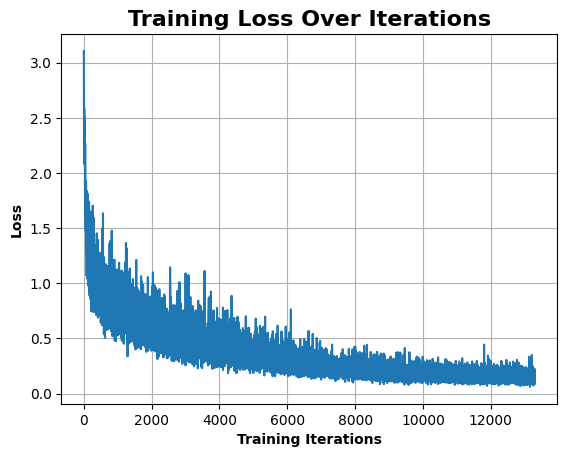

In [13]:
# Make a Plot for the Data
plt.plot(train_loss, label="Training Loss")

# Add Title & Axis Labels
plt.title("Training Loss Over Iterations", fontweight = "bold", fontsize="16")
plt.xlabel("Training Iterations", fontweight = "bold")
plt.ylabel("Loss", fontweight = "bold")

# Add Grid
plt.grid(True)

# Show Plot
plt.show()

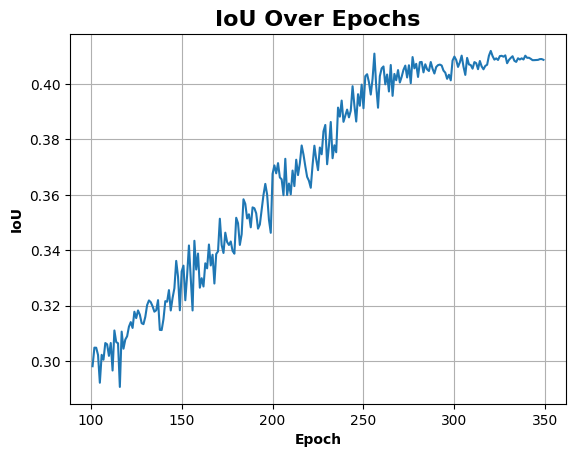

In [14]:
# Epochs from 101 to 350
epochs = list(range(101, 350))  

# Plot IoU vs. Epoch
plt.plot(epochs, IoU_list, label="IoU")

# Add Title & Axis Labels
plt.title("IoU Over Epochs", fontweight = "bold", fontsize="16")
plt.xlabel("Epoch", fontweight = "bold")
plt.ylabel("IoU", fontweight = "bold")

# Add Grid
plt.grid(True)

# Show Plot
plt.show()


**Randomised Prediction Test Results from the Model:**

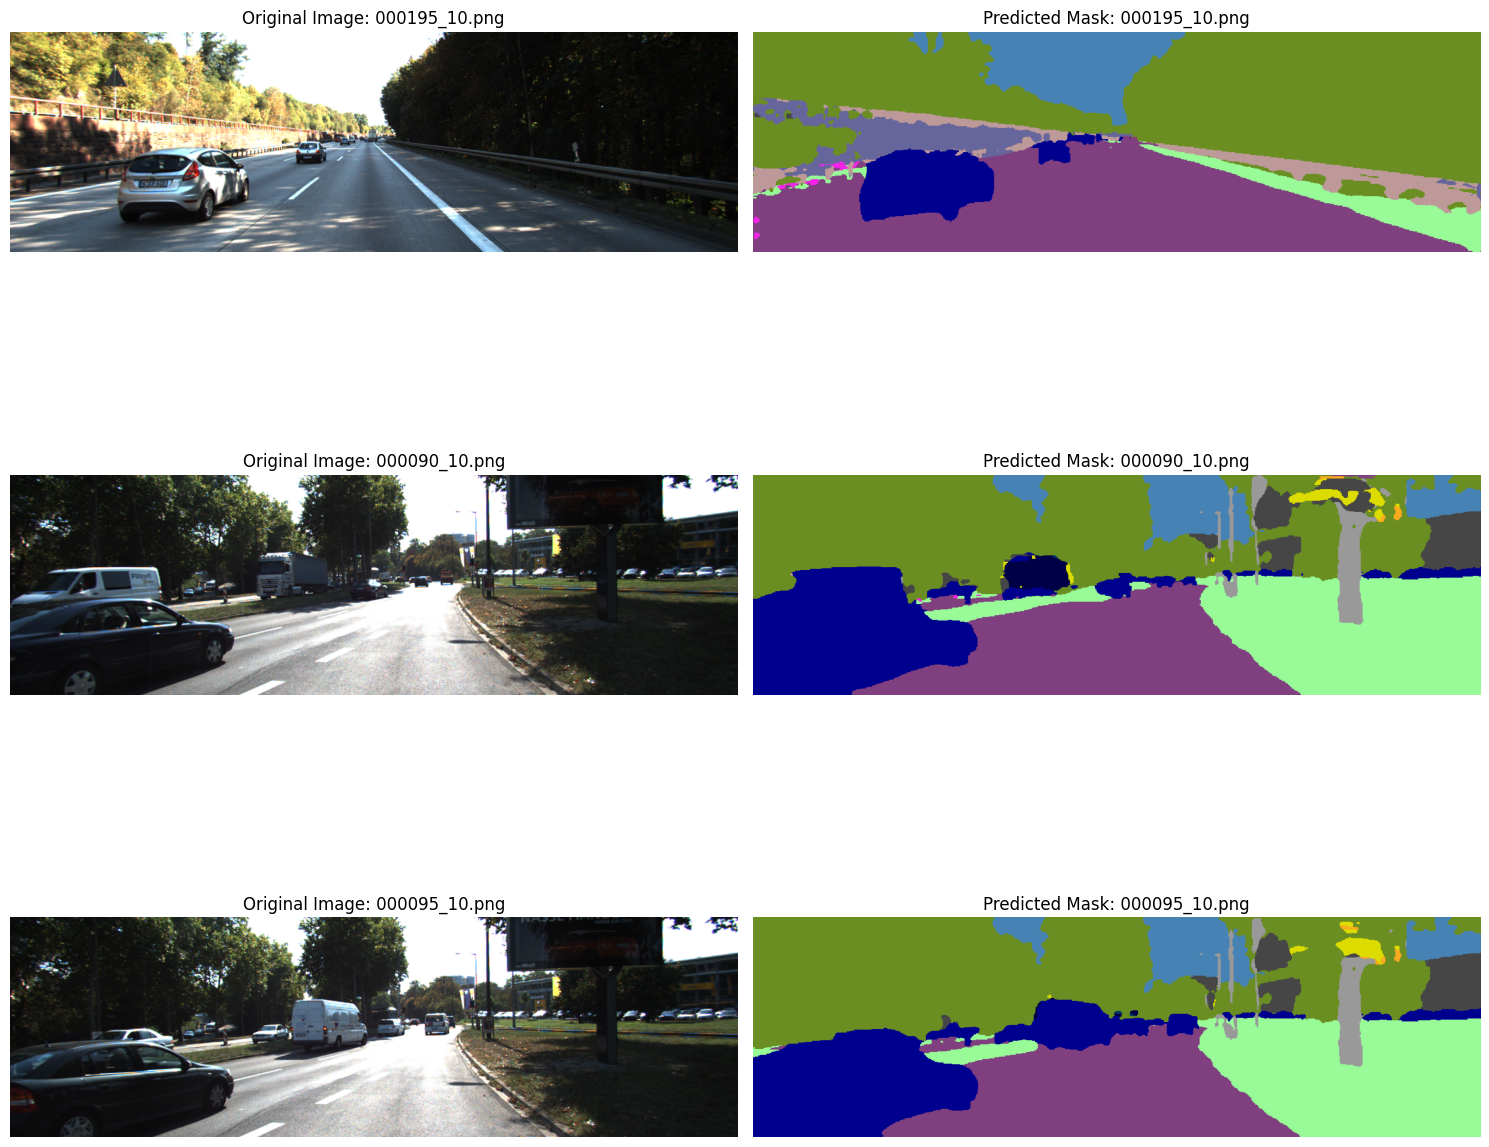

In [15]:
# Define Folder Paths for Predicted Masks & Original Images
temp_color_folder = './TempFiles/color'
train_image_folder = './seg_data/testing/image'

# Call the Function to Display 3 Random Prediction Results
show_random_predictions(temp_color_folder, train_image_folder, num_images=3)

<br/><br>

# **FLOPs**

In deep learning, FLOPs *(Floating Point Operations)* quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass *(i.e. when making a prediction)*. This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs *(Giga Floating Point Operations)*, where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

**DO NOT MODIFT THIS CODE!**

In [16]:
# We use Fvcore to Calculate the FLOPs
!pip3 install fvcore

In [17]:
from fvcore.nn import FlopCountAnalysis

# Modifying the Size (3, 375, 1242) is ***NOT*** Allowed
input = torch.randn(1, 3, 375, 1242)

# Get the Network & its FLOPs
model = BetterSegNetwork(n_class=19)
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.2f} GFLOPs")

Unsupported operator aten::max_pool2d encountered 4 time(s)
Unsupported operator aten::feature_dropout encountered 3 time(s)
Unsupported operator aten::add_ encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
conv1_3, conv2_3, conv3_3, conv4_3, conv5_3, drop4_3, drop5_3, gn1_3, gn2_3, gn3_3, gn4_3, gn5_3, relu1_3, relu2_3, relu3_3, relu4_3, relu5_3


FLOPs: 227.65 GFLOPs
